In [1]:
# Starter

__author__ = "Philipp Kats"
from datetime import date
__date__ = date.today().strftime('%Y-%m-%d')

%matplotlib inline
import pylab as plt
plt.style.use('fivethirtyeight')

import pandas as pd
import geopandas as gp
import os
import json
import SE
import altair as alt

from tqdm import tqdm, tqdm_notebook
# tqdm().pandas()
#from hyperdash import monitor_cell, Experiment
 

from SE.areas import get_all_areas, get_larger_area
from SE.sql import _get_DF
from SE import definitions
#from SE.sql import queries
idx = pd.IndexSlice

print(__date__)
print(SE.__version__)

2018-09-11
5.8.6


In [2]:
from rasterio import features, Affine, float64
from rasterio.enums import MergeAlg
from xarray import DataArray
import numpy as np

import datashader as ds
from datashader import transfer_functions as tf, reductions as rd
from datashader.colors import Hot, viridis

import colorcet
kbc = colorcet.cm.kbc

In [3]:
def get_transform(cvs):
    '''transform into canvas coordinates'''
    return Affine((cvs.x_range[1] - cvs.x_range[0]) / cvs.plot_width, 0.0,
                   cvs.x_range[0], 0.0, (cvs.y_range[0] - cvs.y_range[1]) / cvs.plot_height, cvs.y_range[1])

In [8]:
from SE.spatial import get_better_boundaries, NYC_CRS, MERCATOR_CRS
nyc = get_better_boundaries(area_type='city', nyc_crs=True).iloc[0]

In [5]:
cb = pd.read_pickle('../data/correct_geom.pkl')

In [6]:
cb['boundary_name'] = cb['boundary_name'].str.lower()

In [9]:
print(nyc['geometry'].envelope.buffer(.05).envelope)


POLYGON ((912612.5756563748 119435.5517043253, 1068023.635515791 119435.5517043253, 1068023.635515791 273101.639647286, 912612.5756563748 273101.639647286, 912612.5756563748 119435.5517043253))


In [10]:
cvs = ds.Canvas(plot_height=2000,
                plot_width=2000,
                x_range=(912_612, 1_068_023),
                y_range=(119435, 273101))

aform = get_transform(cvs)
aform

Affine(77.7055, 0.0, 912612.0,
       0.0, -76.833, 273101.0)

In [11]:
border = features.rasterize([nyc.geometry.boundary], 
                            out_shape=(cvs.plot_height, cvs.plot_width),
                            merge_alg=MergeAlg.replace, transform=aform, all_touched=True, dtype=float64)

border[border == 0] = np.nan
bd = DataArray(data=pd.np.flipud(border))

## Walkable

In [7]:
walk = cb[cb.boundary_name.str.contains(r'walk')]
len(walk)

713

In [20]:
walk['boundary_name'].value_counts().head(5)

walk to work        48
walking distance    46
walking             24
walkable            18
walk                10
Name: boundary_name, dtype: int64

In [15]:
F = features.rasterize([(el, 1) for el in walk['geometry'].tolist()], 
                        out_shape=(cvs.plot_height, cvs.plot_width),
                        merge_alg=MergeAlg.add, transform=aform, dtype=float64)

data = DataArray(data=pd.np.flipud(F))

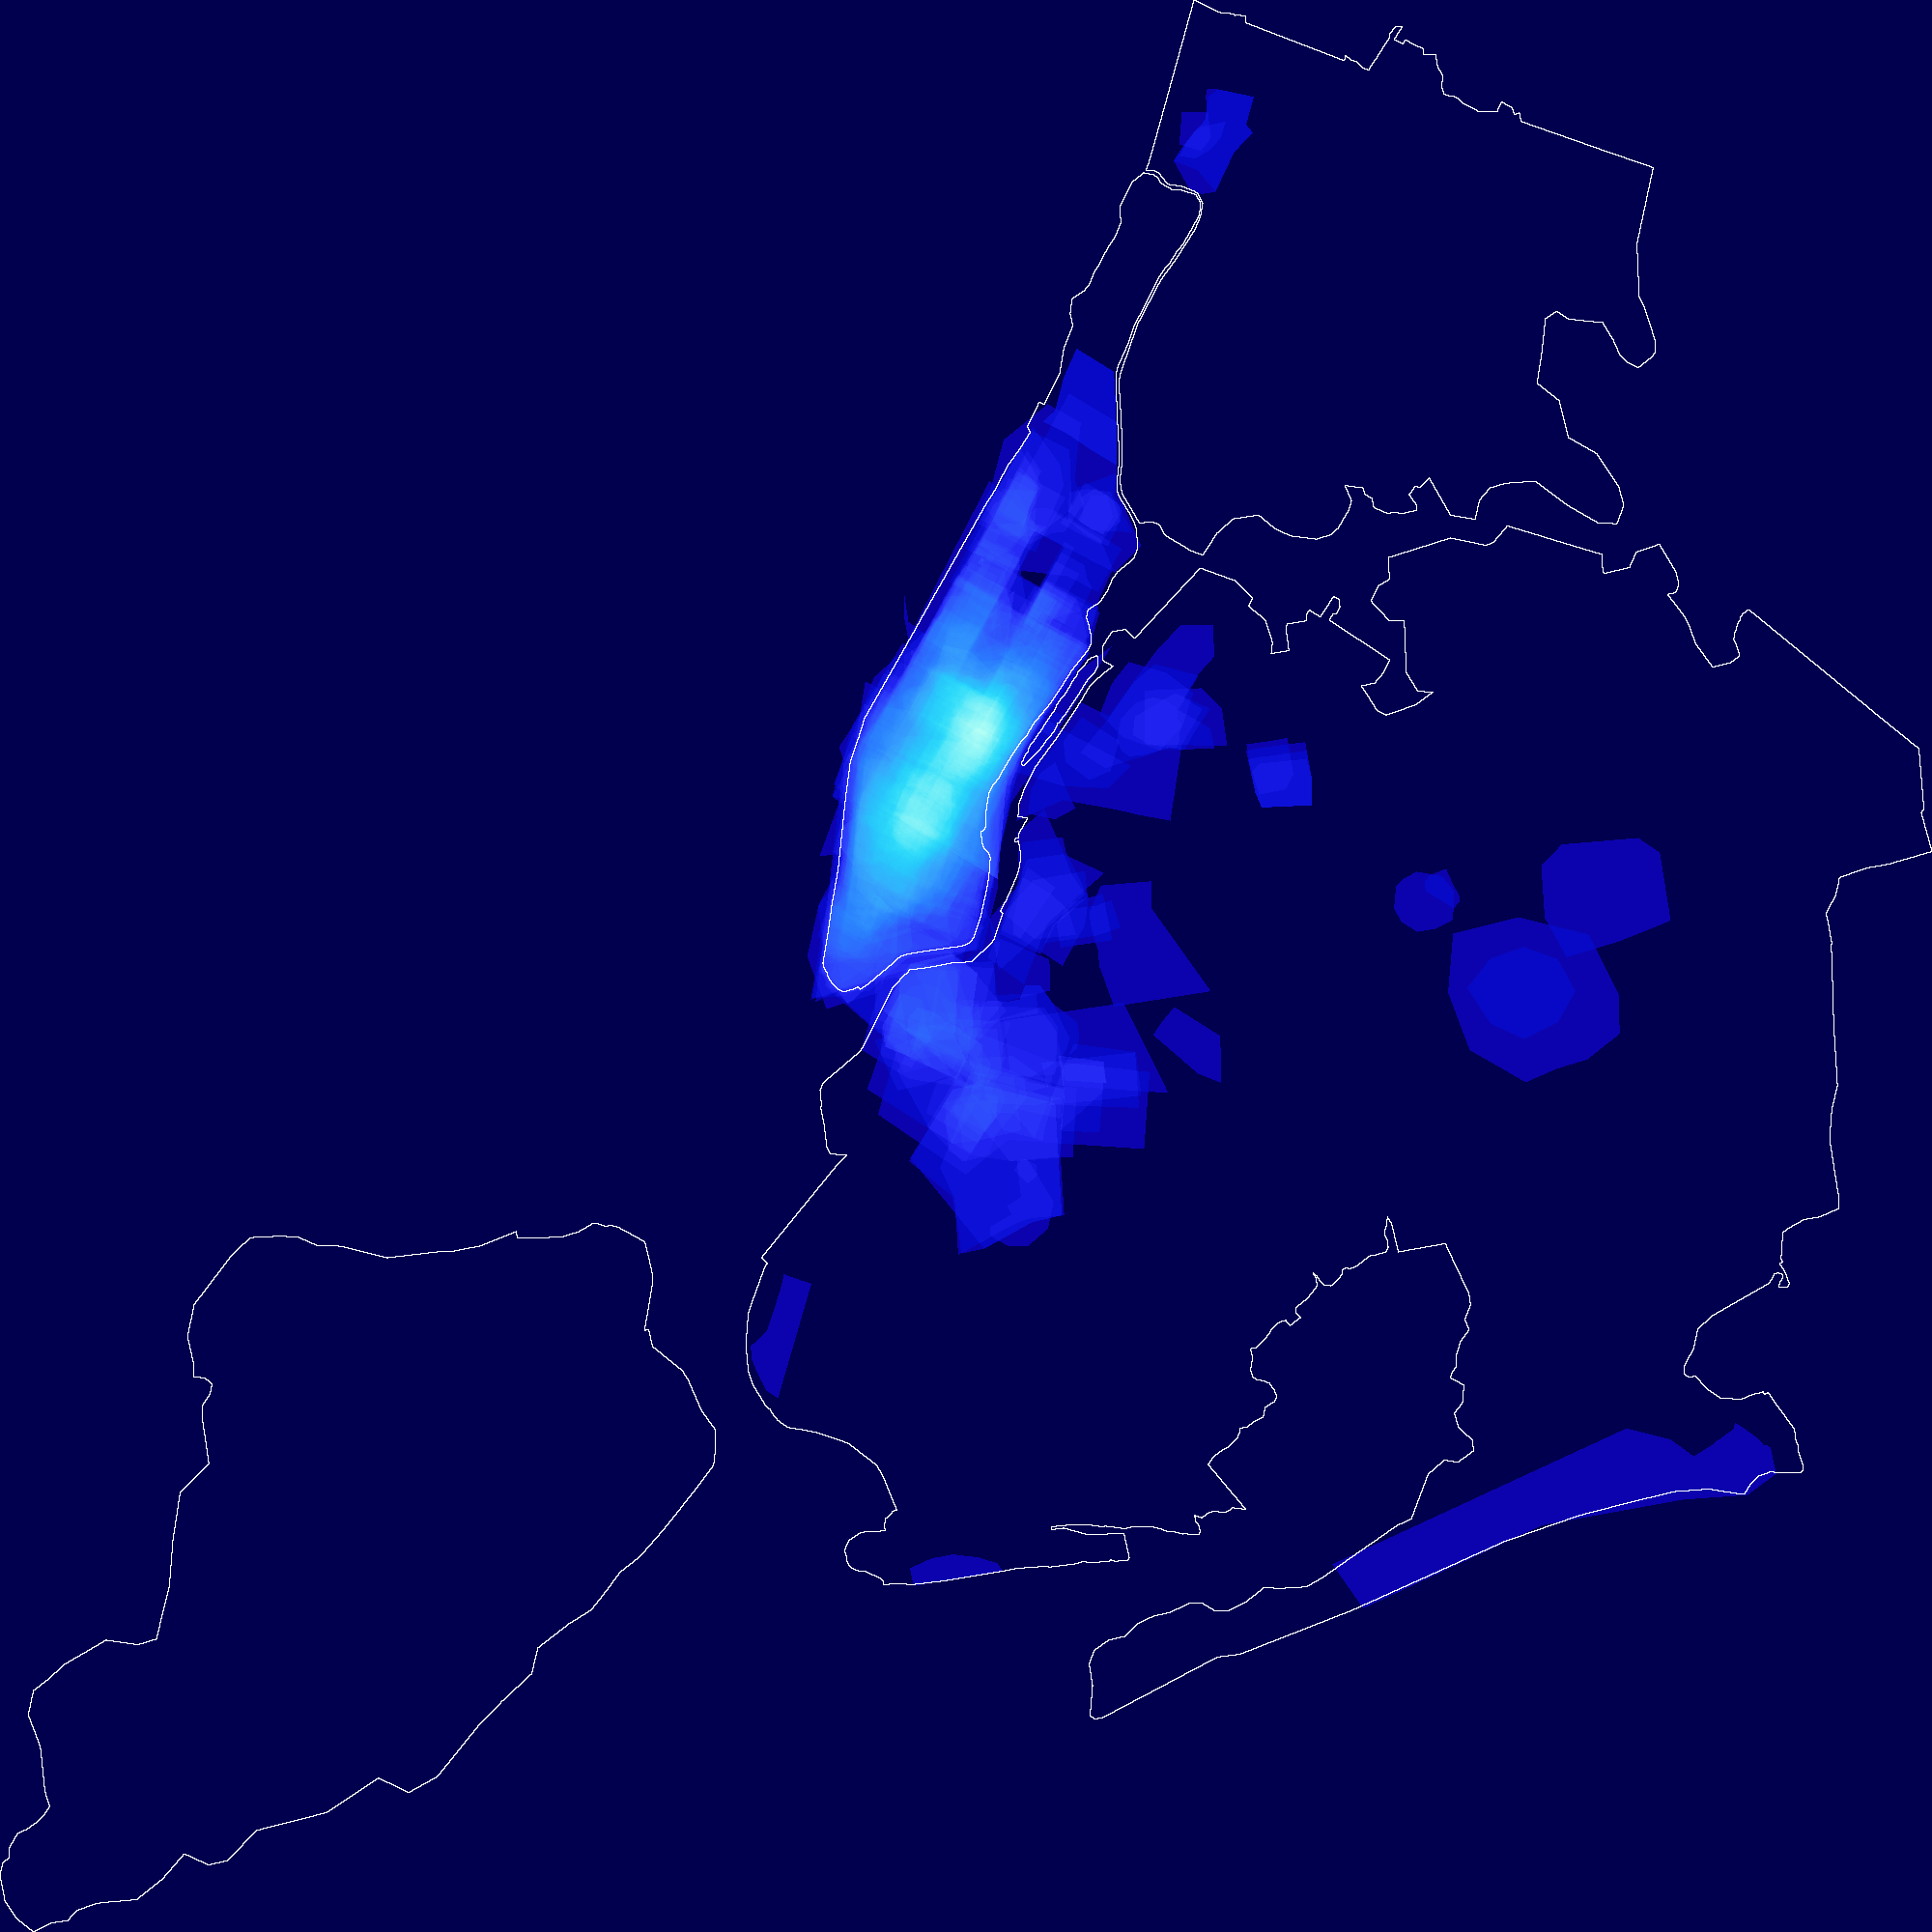

In [17]:
tf.stack(tf.shade(data, how='cbrt', cmap=kbc, name='Density'),
         tf.shade(bd, how='eq_hist', cmap=['black','white']))

In [23]:
F2 = features.rasterize([(el, 1) for el in walk['geometry'].boundary.tolist()], 
                        out_shape=(cvs.plot_height, cvs.plot_width),
                        merge_alg=MergeAlg.add, transform=aform, dtype=float64)

data2 = DataArray(data=pd.np.flipud(F2))

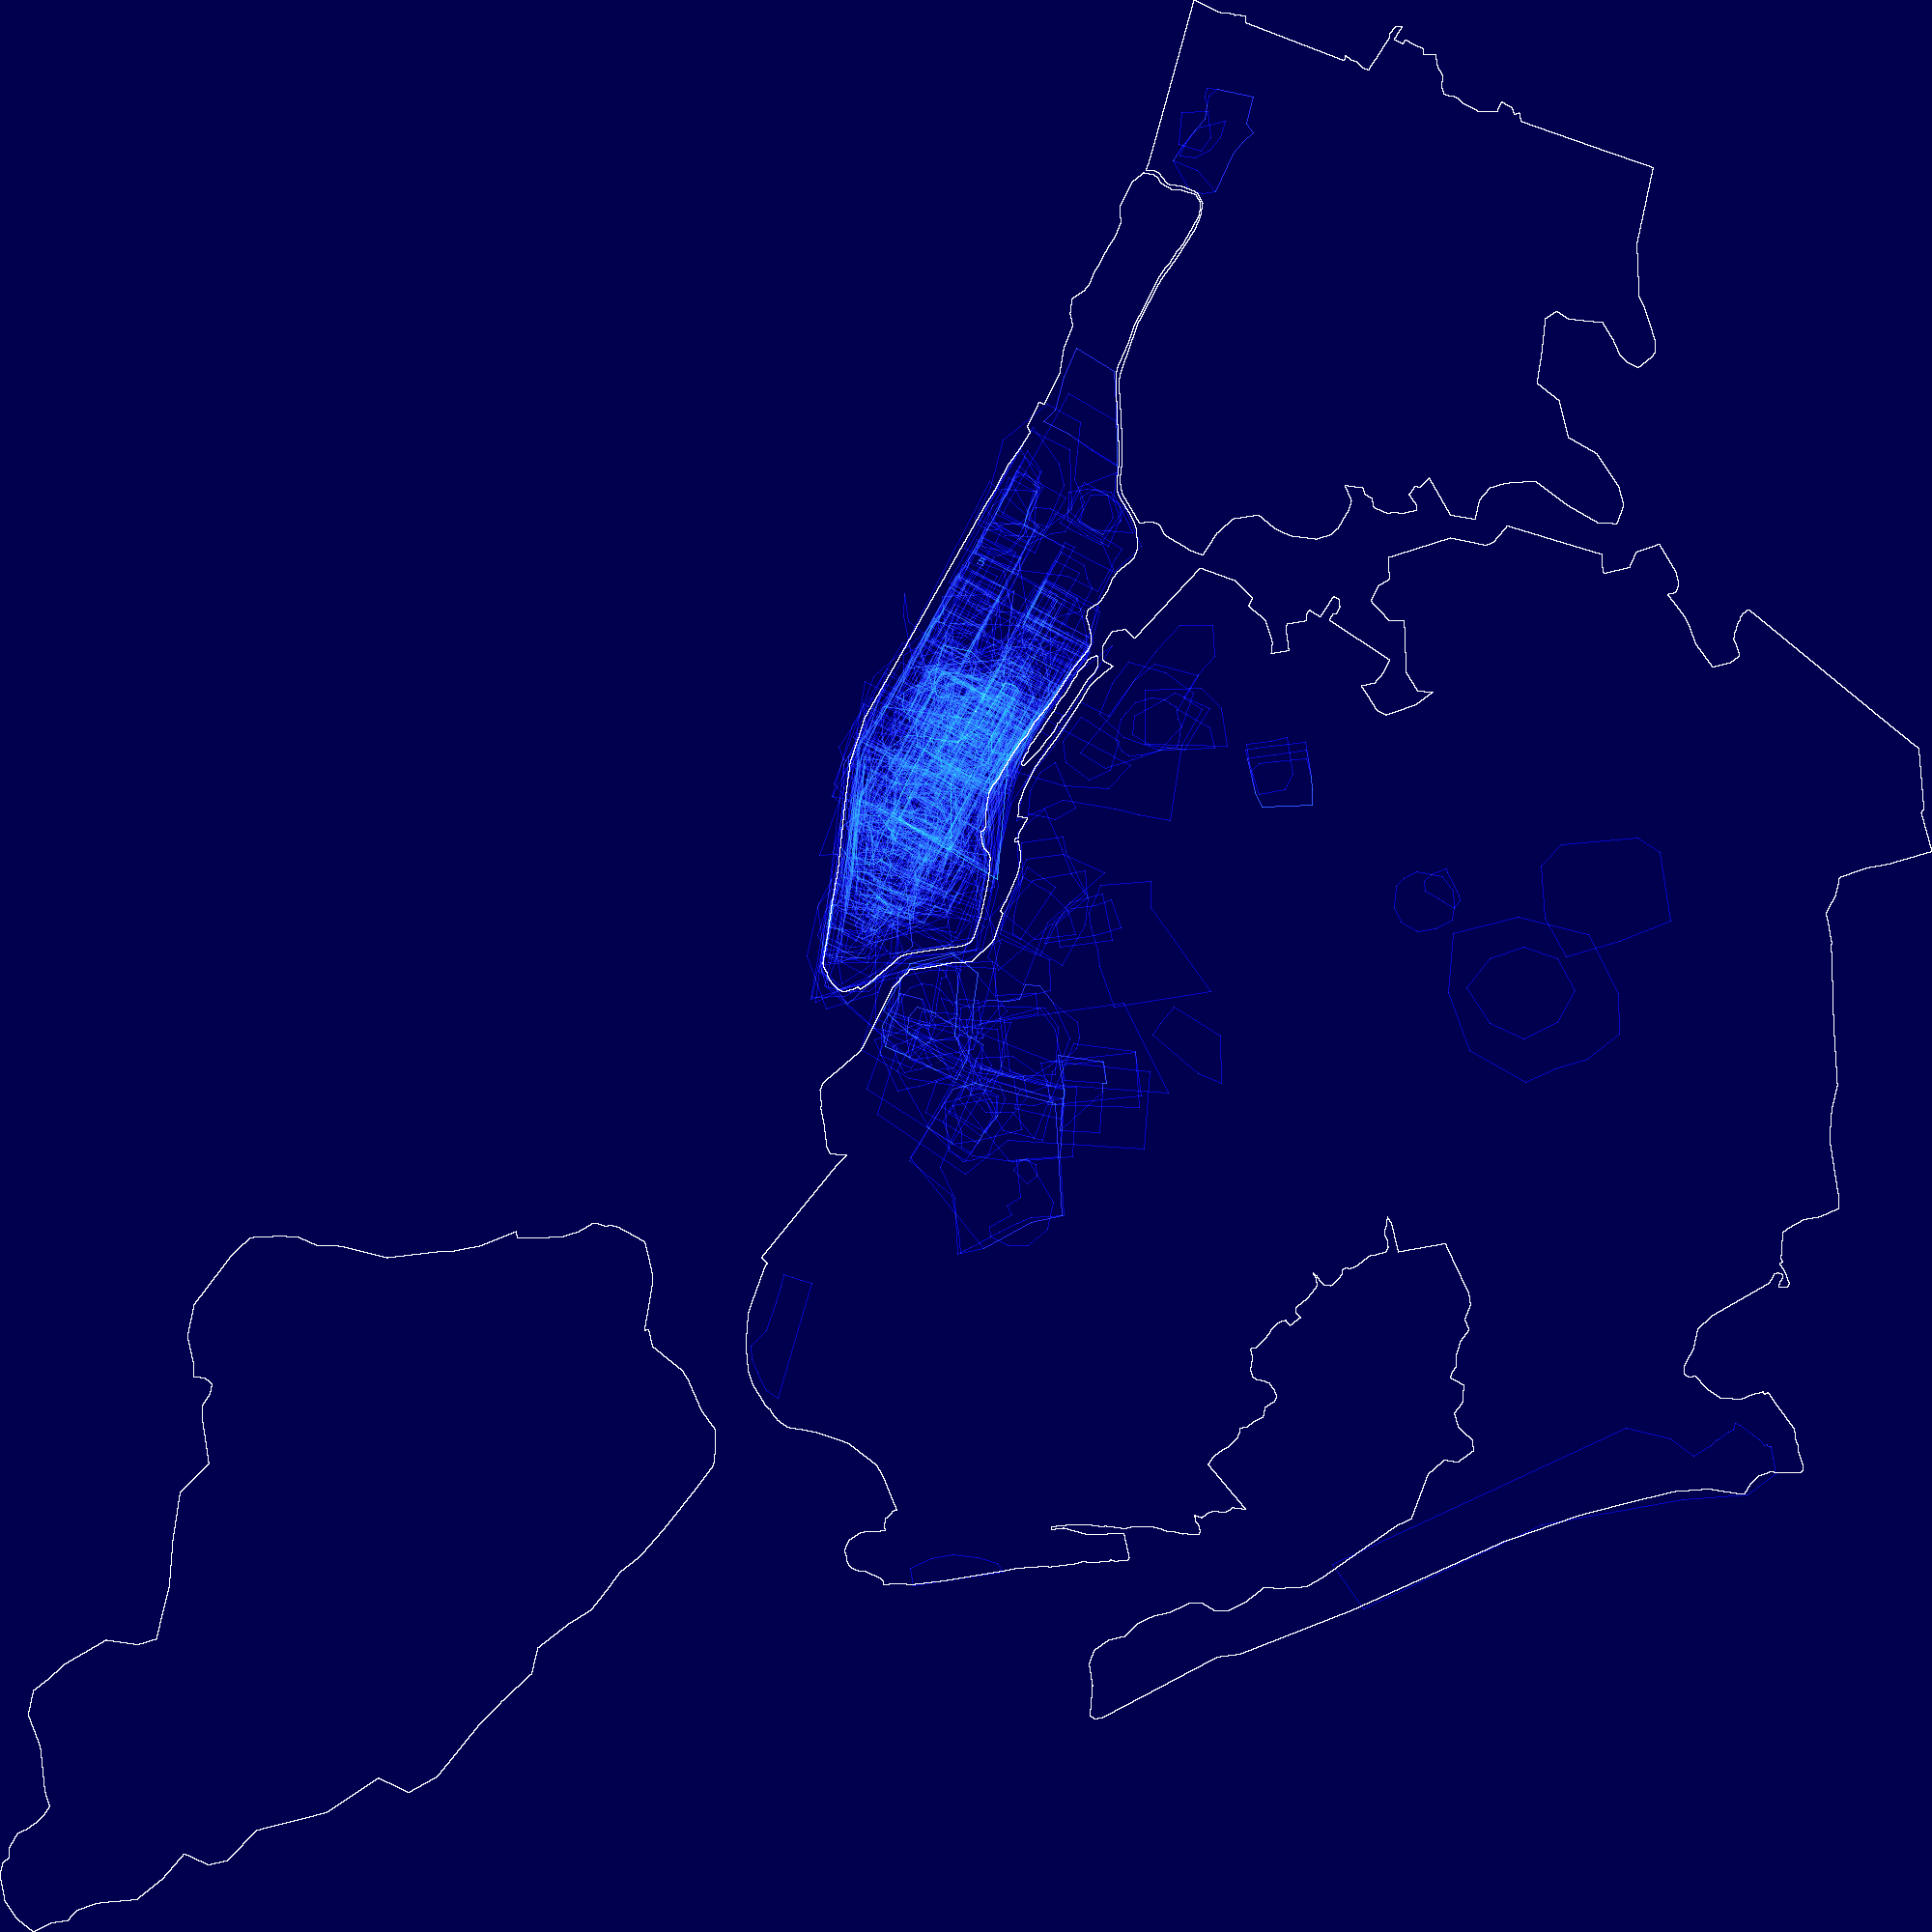

In [27]:
tf.stack(tf.shade(data2, how='log', cmap=kbc, name='Density'),
         tf.shade(bd, how='eq_hist', cmap=['black','white']))

## Whole Foods

In [30]:
WH = cb[cb.boundary_name.str.contains(r'foods')]
len(WH)

54

In [31]:
WH['boundary_name'].value_counts().head(5)

whole foods                                 6
60's area (near whole foods and equinox)    4
uws whole foods                             3
by wholefoods                               2
whole foods harlem                          2
Name: boundary_name, dtype: int64

In [32]:
F = features.rasterize([(el, 1) for el in WH['geometry'].tolist()], 
                        out_shape=(cvs.plot_height, cvs.plot_width),
                        merge_alg=MergeAlg.add, transform=aform, dtype=float64)

data = DataArray(data=pd.np.flipud(F))

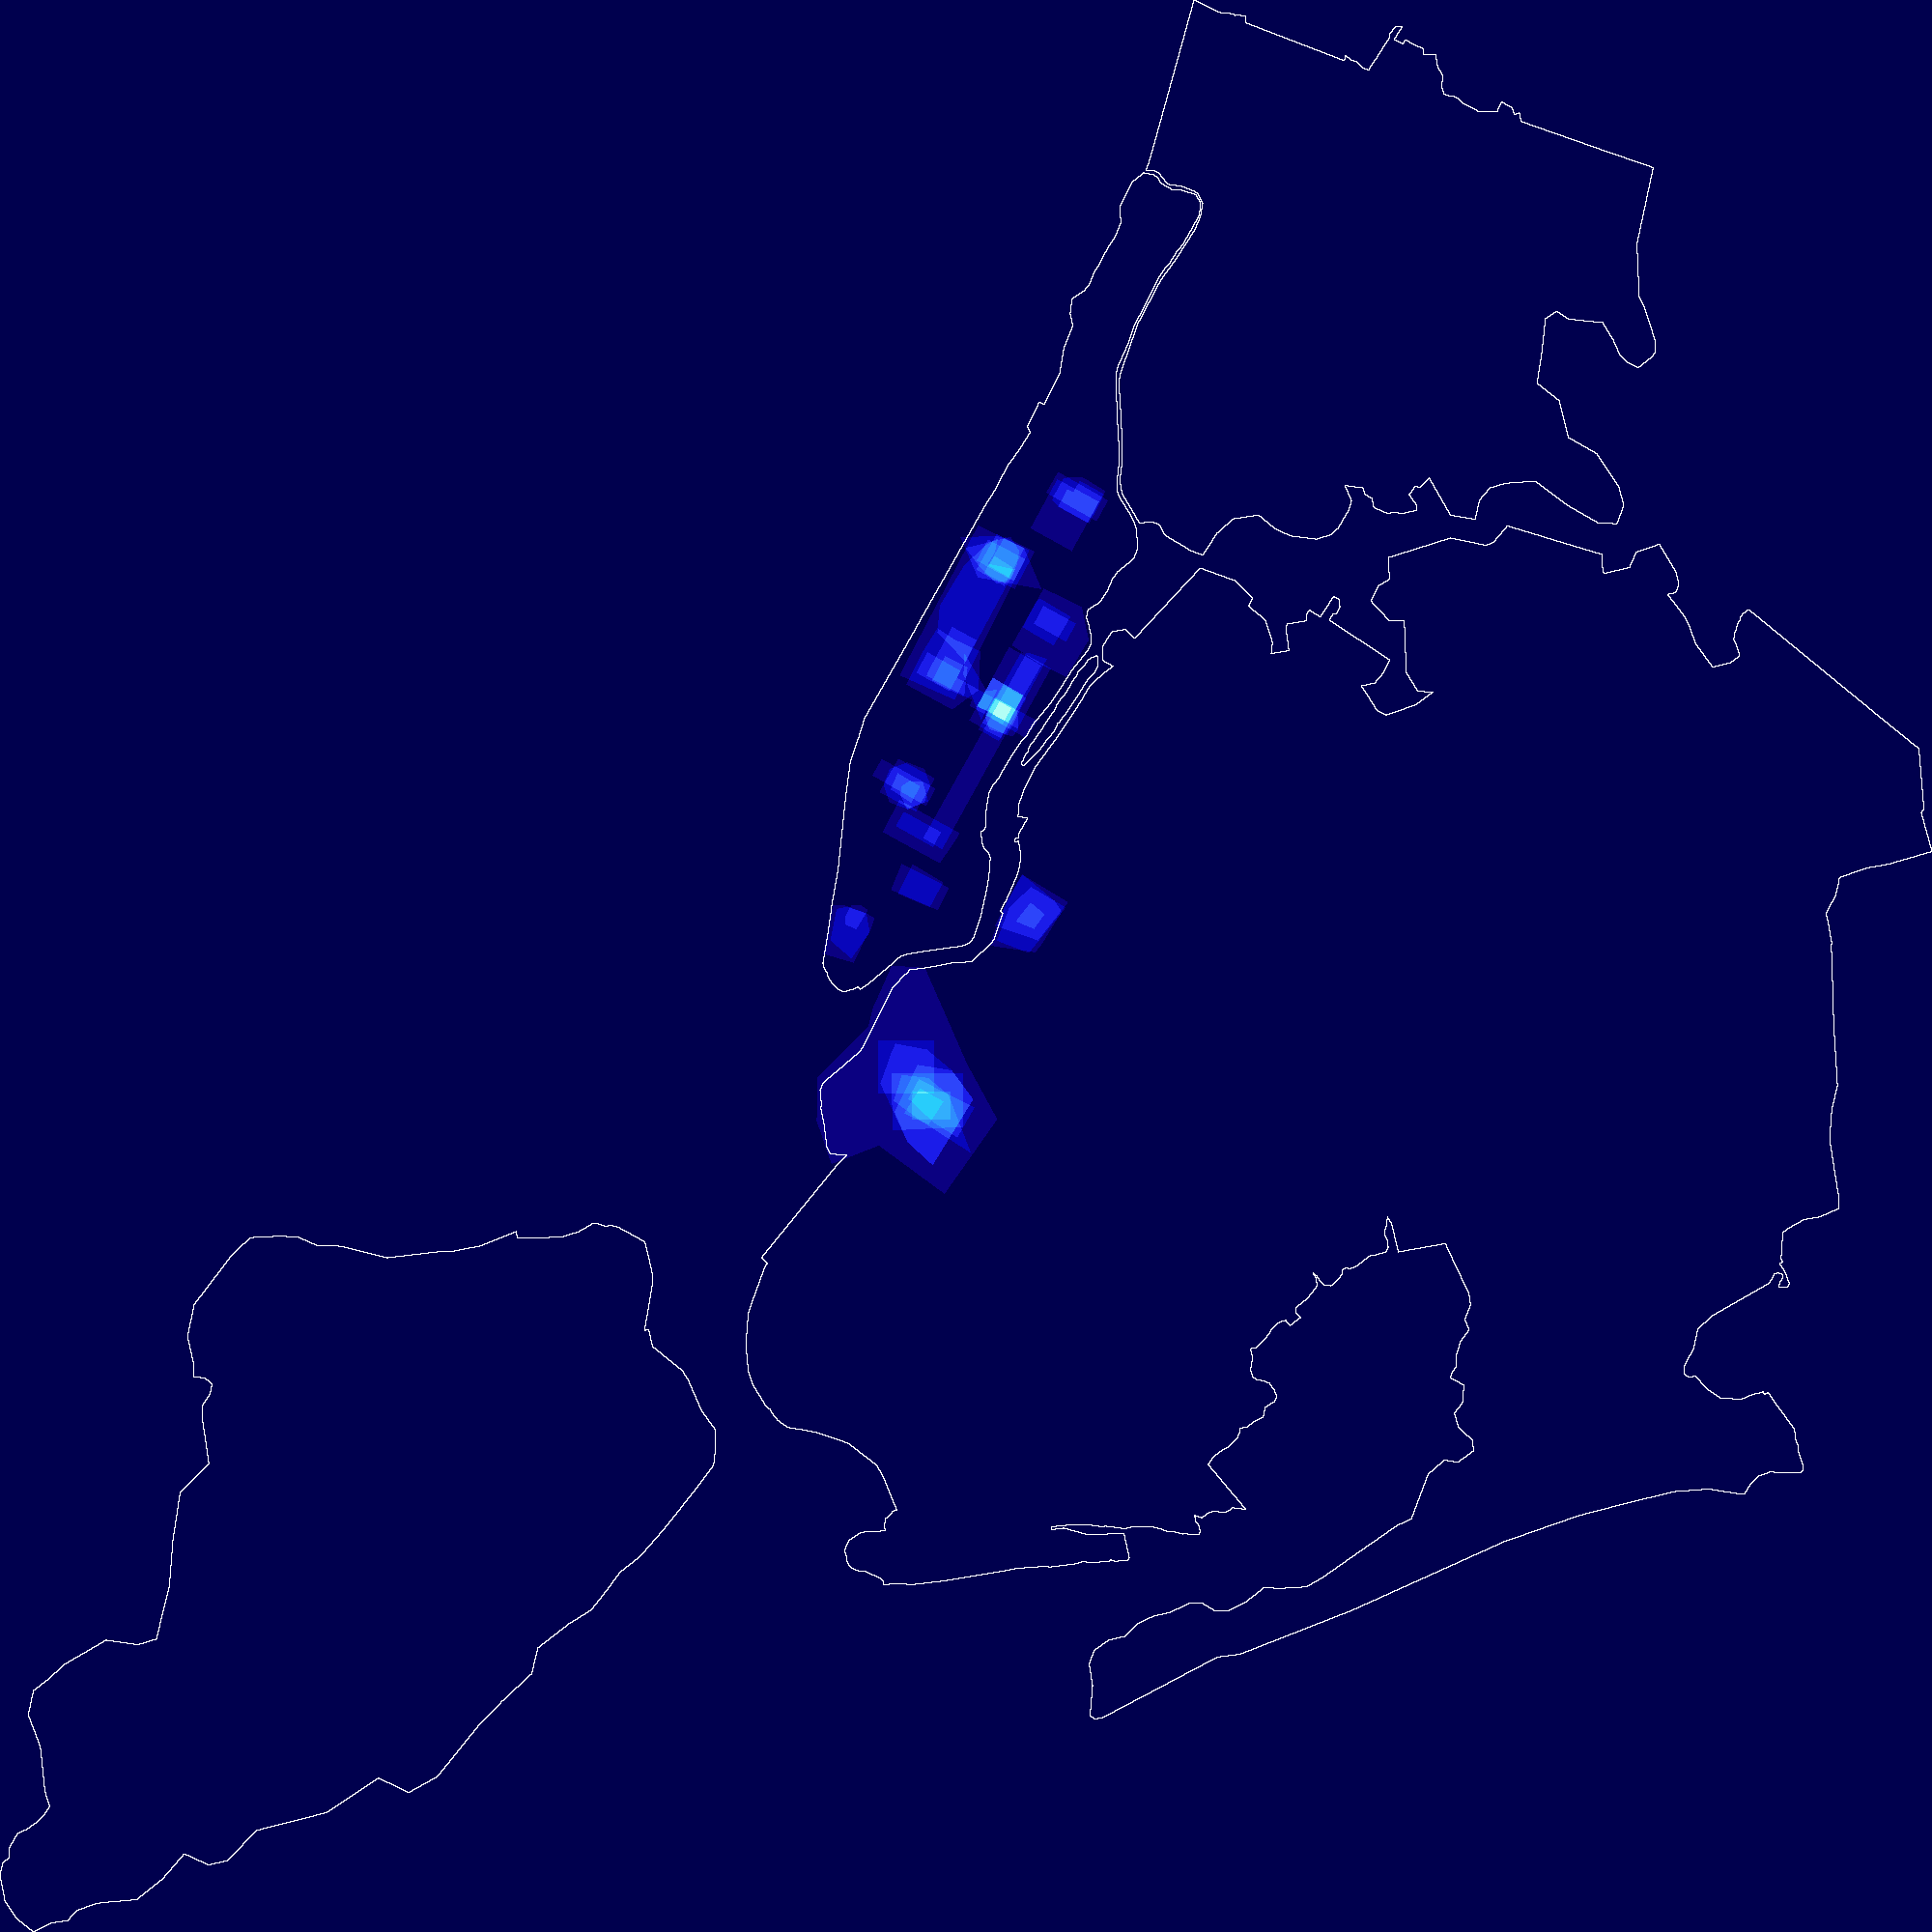

In [34]:
tf.stack(tf.shade(data, how='linear', cmap=kbc, name='Density'),
         tf.shade(bd, how='eq_hist', cmap=['black','white']))

## Equinox

In [35]:
EQ = cb[cb.boundary_name.str.contains(r'equinox')]
len(EQ)

69

In [36]:
EQ['boundary_name'].value_counts().head(5)

equinox                                     10
60's area (near whole foods and equinox)     4
near equinox                                 2
near soho equinox                            2
greenwich village equinox                    2
Name: boundary_name, dtype: int64

In [37]:
F = features.rasterize([(el, 1) for el in EQ['geometry'].tolist()], 
                        out_shape=(cvs.plot_height, cvs.plot_width),
                        merge_alg=MergeAlg.add, transform=aform, dtype=float64)

data = DataArray(data=pd.np.flipud(F))

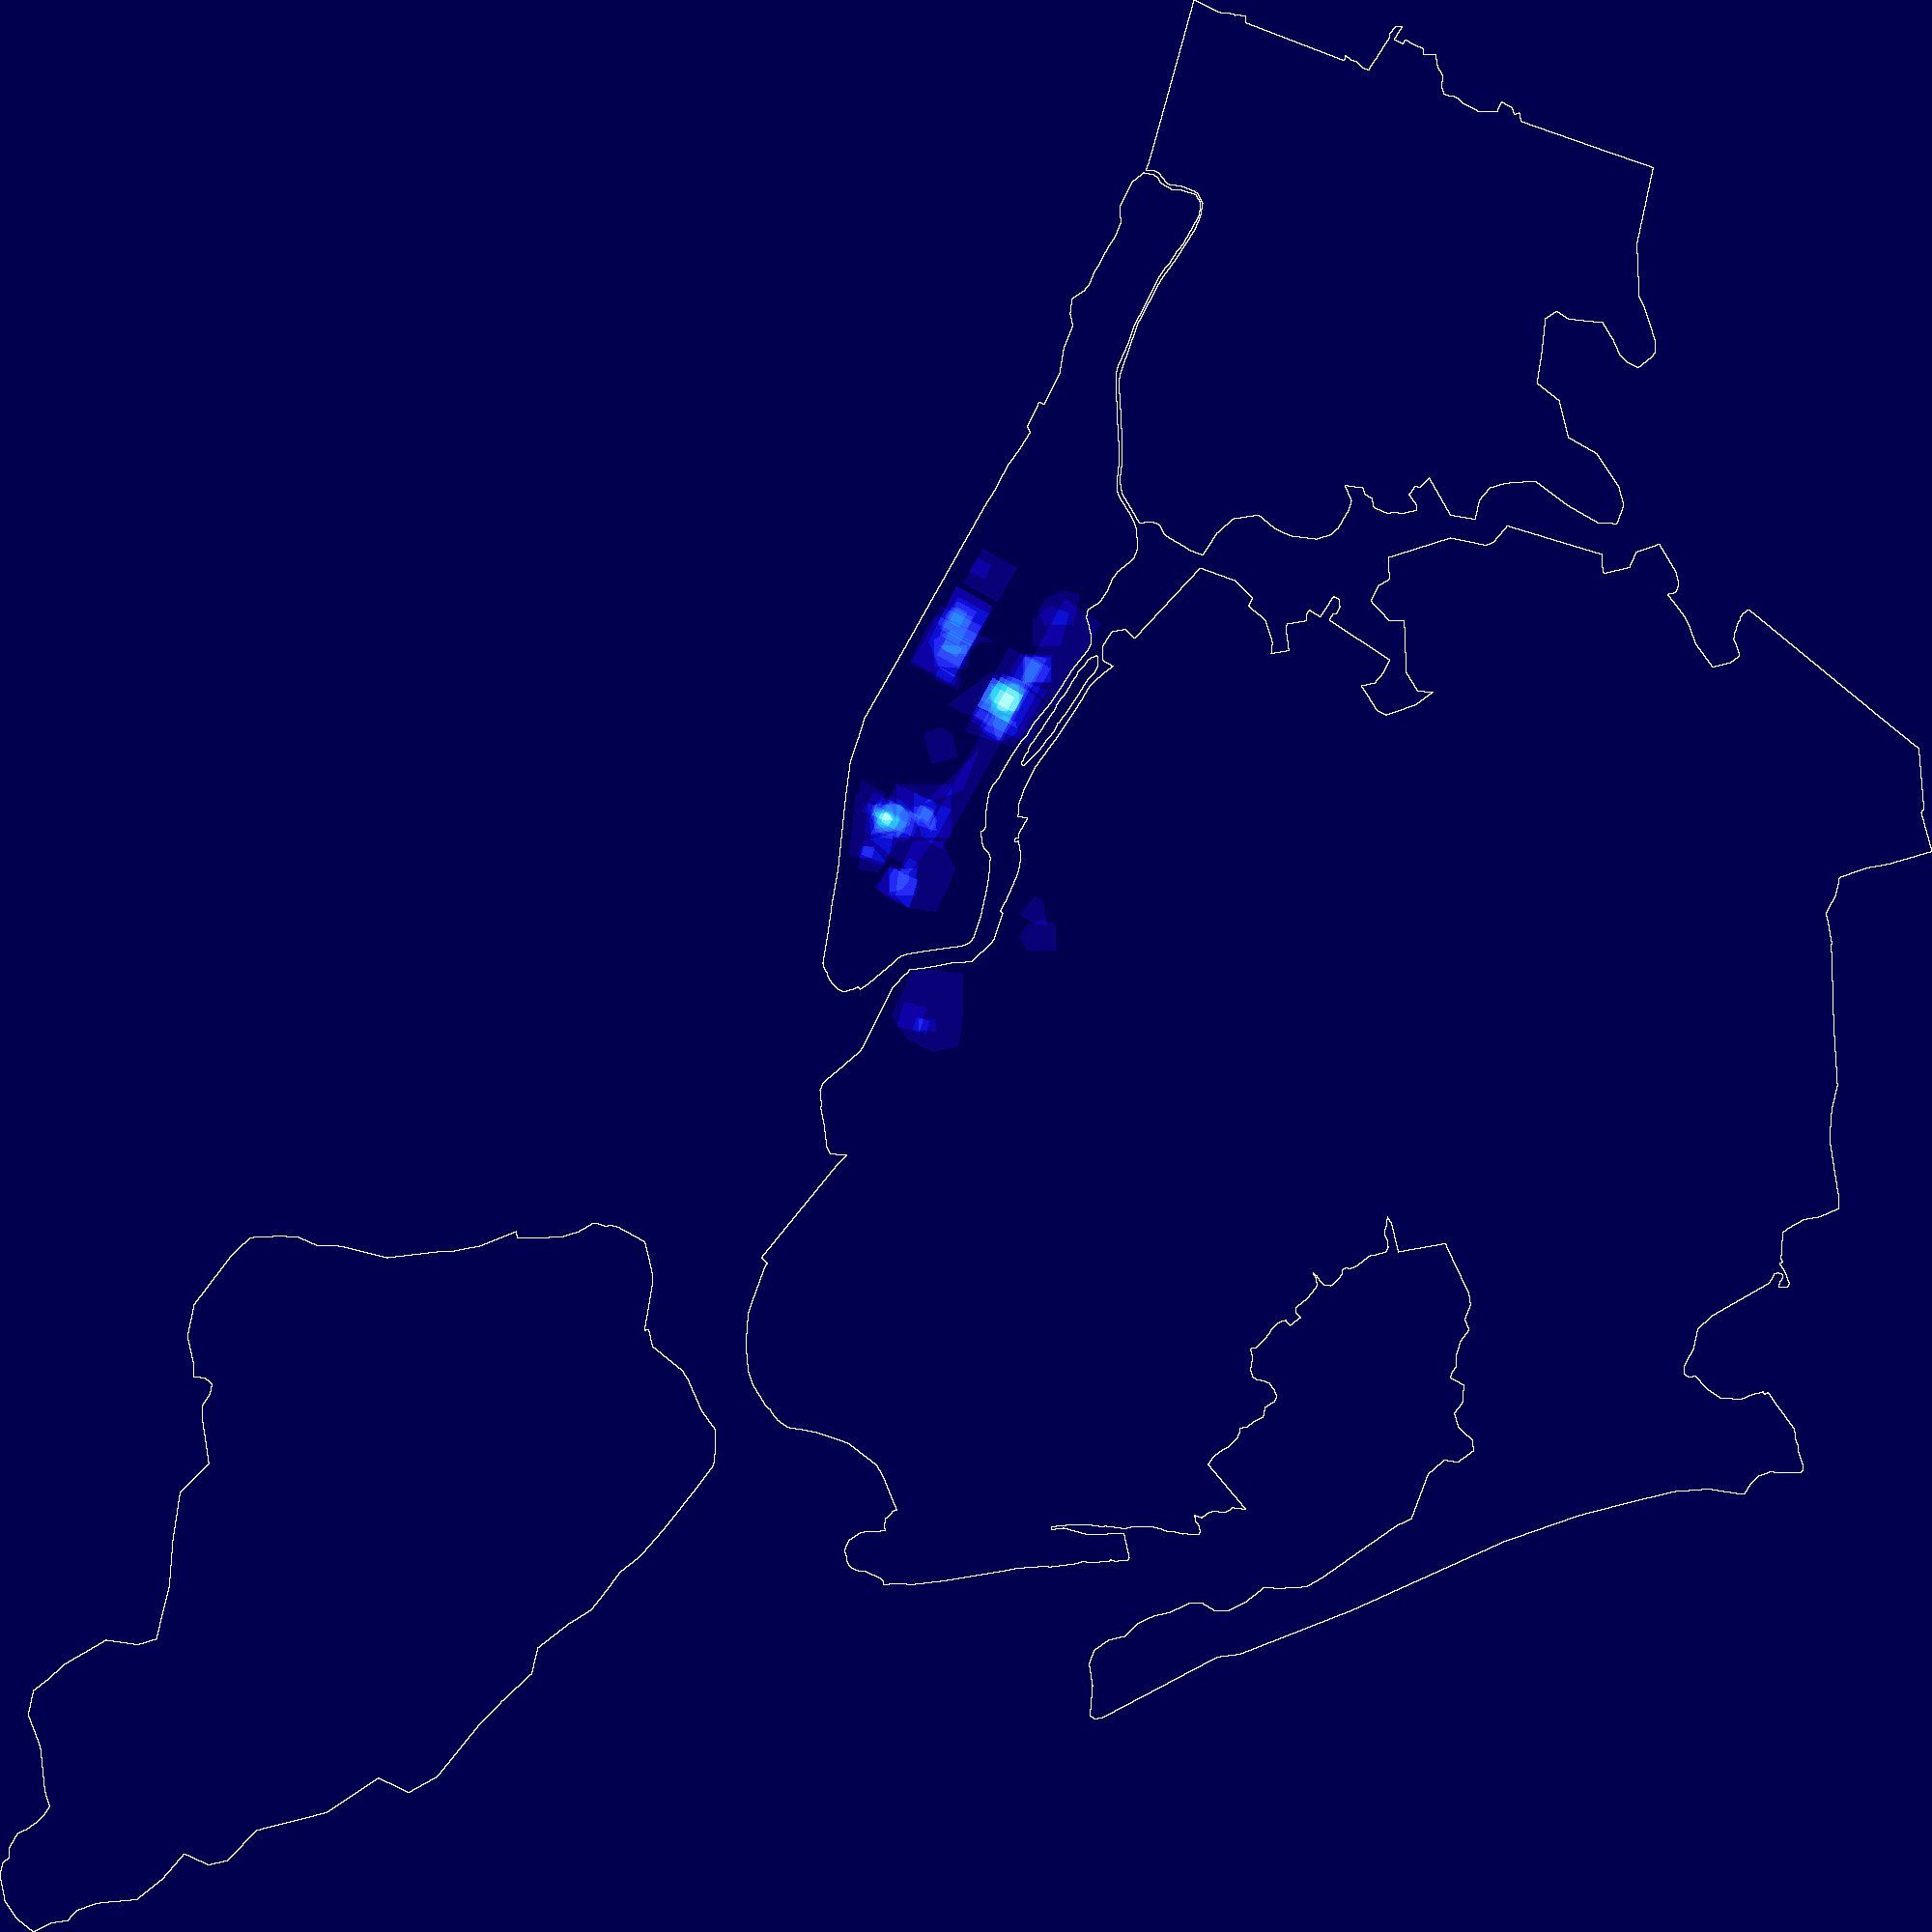

In [38]:
tf.stack(tf.shade(data, how='linear', cmap=kbc, name='Density'),
         tf.shade(bd, how='eq_hist', cmap=['black','white']))

## Prospect Park

In [39]:
PP = cb[cb.boundary_name.str.contains(r'prospect park')]
len(PP)

689

In [40]:
PP['boundary_name'].value_counts().head(5)

prospect park           202
around prospect park     34
prospect park area       33
near prospect park       27
prospect park south      15
Name: boundary_name, dtype: int64

In [41]:
F = features.rasterize([(el, 1) for el in PP['geometry'].tolist()], 
                        out_shape=(cvs.plot_height, cvs.plot_width),
                        merge_alg=MergeAlg.add, transform=aform, dtype=float64)

data = DataArray(data=pd.np.flipud(F))

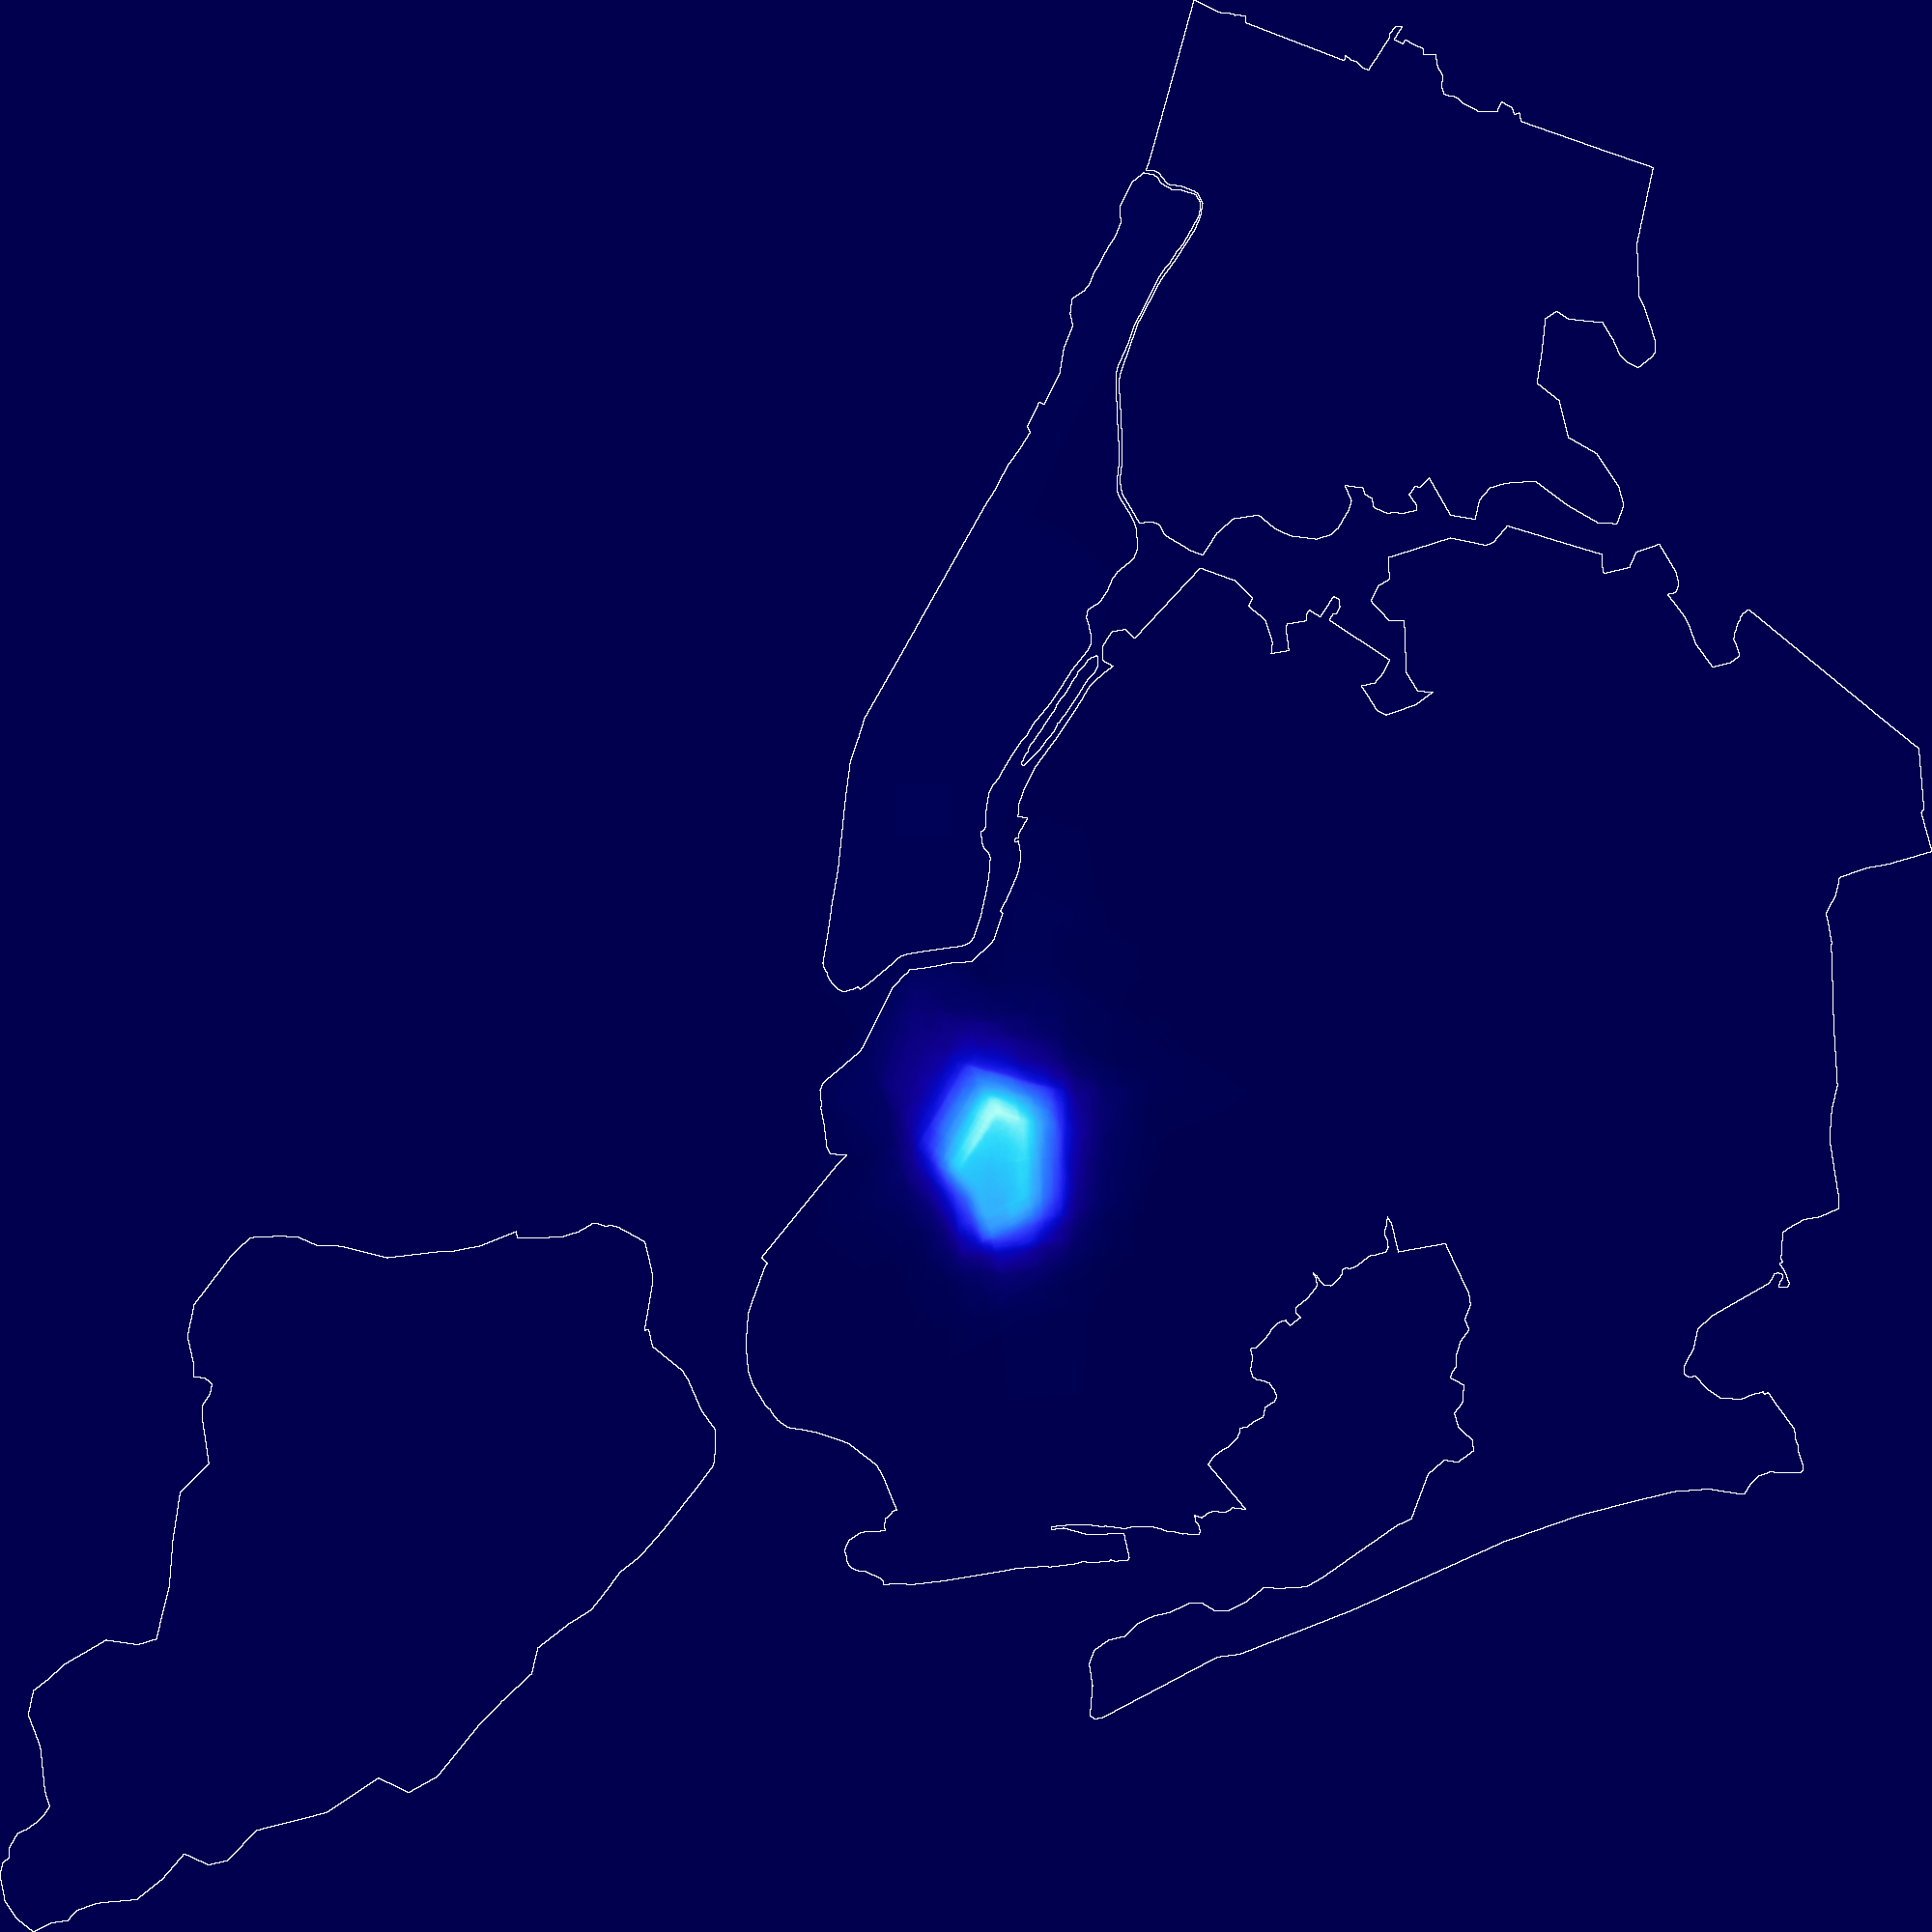

In [42]:
tf.stack(tf.shade(data, how='linear', cmap=kbc, name='Density'),
         tf.shade(bd, how='eq_hist', cmap=['black','white']))